# Self-Attention Interpolation Demo
Pipeline with synthetic data, ensembling, smoothing, and visualizations.

In [1]:
# Imports 
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
plt.style.use("ggplot")  # consistent aesthetics
from sainterpolate.ast_transformer import (
    set_seed,
    make_synthetic_data,
    process_and_interpolate_results,
    ensemble_scores,
    smooth_results,
)

In [2]:
# Visualization functions
def _pid_color_map(ids, cmap_name="tab10"):
    cmap = mpl.cm.get_cmap(cmap_name, 10)
    unique_ids = sorted(set(ids))
    return {pid: cmap(i % 10) for i, pid in enumerate(unique_ids)}


def plot_raw_assessments(
    ast_df,
    score_col="ast",
    id_col="patid",
    title="Raw synthetic assessment observations",
    marker="o",
    figsize=(9, 5),
    cmap_name="tab10",
):
    """
    Scatter plot of raw (non-imputed) assessment values per participant,
    colored by participant using a tab10 colormap.
    """
    pid_colors = _pid_color_map(ast_df[id_col].unique(), cmap_name=cmap_name)

    fig, ax = plt.subplots(figsize=figsize)

    for pid, dfu in ast_df.groupby(id_col):
        dfu2 = dfu.dropna(subset=[score_col]).sort_values("date")
        ax.plot(
            dfu2["date"],
            dfu2[score_col],
            marker=marker,
            linestyle="",
            label=f"{id_col} {pid}",
            color=pid_colors[pid],
            mec="none",
        )

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel(score_col)

    # Format x ticks as yy-mm
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m"))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Legend below plot in a single row
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=len(ast_df[id_col].unique()),
        frameon=False,
    )

    plt.tight_layout()
    plt.show()


def plot_pat_series_with_assessments(
    df,
    ast_df,
    score_cols,
    title_prefix="Scores",
    cmap_name="tab10",
    line_alpha=0.9,
    assess_marker="o",
):
    """
    Plot per-participant time series (lines from df[score_cols]) and overlay the
    synthetic assessment points from ast_df as circle markers. Colors are
    consistent per participant using tab10.
    """
    pid_colors = _pid_color_map(df["patid"].unique(), cmap_name=cmap_name)

    for pid in sorted(df["patid"].unique()):
        fig, ax = plt.subplots(figsize=(9, 4))
        pat_df = df[df["patid"] == pid].sort_values("date")
        ast_pat = ast_df[(ast_df["patid"] == pid) & ast_df["ast"].notna()].sort_values("date")

        # Plot lines for requested score columns; use participant color
        for col in score_cols:
            ax.plot(
                pat_df["date"],
                pat_df[col],
                label=f"{col}",
                color=pid_colors[pid],
                alpha=line_alpha,
            )

        # Overlay synthetic assessment markers
        if not ast_pat.empty:
            ax.scatter(
                ast_pat["date"],
                ast_pat["ast"],
                marker=assess_marker,
                facecolors="white",
                edgecolors=pid_colors[pid],
                linewidths=1.5,
                s=36,
                label="synthetic ast",
            )

        ax.set_title(f"{title_prefix} for participant {pid}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Score")

        # Format x ticks as yy-mm
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m"))
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

        # Legend below plot in a single row
        ax.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, -0.15),
            ncol=len(score_cols) + 1,
            frameon=False,
        )

        plt.tight_layout()
        plt.show()

def plot_ensemble_vs_smoothed_with_assessments(
    ensembled,
    smoothed,
    ast_df,
    id_col="patid",
    score_col="ast",
    title_prefix="Ensemble vs Smoothed",
    cmap_name="tab10",
    figsize=(9, 4),
    line_alpha=0.95,
    assess_marker="o",
    assess_size=36,
    line_colors=None,  # NEW: tuple/list (ensemble_color, smoothed_color)
):
    """
    Plot ensemble (solid) vs smoothed (dashed) per participant and overlay
    synthetic assessment points (hollow circles). Lines use two distinct colors;
    assessment markers use the participant's tab10 color.

    Args:
        line_colors: (ensemble_color, smoothed_color). If None, uses tab10[0], tab10[1].
    """
    # Colors for lines
    if line_colors is None:
        tab10 = mpl.cm.get_cmap("tab10", 10)
        ensemble_color = tab10(0)  # blue-ish
        smoothed_color = tab10(1)  # orange-ish
    else:
        ensemble_color, smoothed_color = line_colors

    # Colors for assessment markers by participant
    pid_colors = _pid_color_map(ensembled[id_col].unique(), cmap_name=cmap_name)

    for pid in sorted(ensembled[id_col].unique()):
        fig, ax = plt.subplots(figsize=figsize)

        e = ensembled[ensembled[id_col] == pid].sort_values("date")
        s = smoothed[smoothed[id_col] == pid].sort_values("date")
        a = ast_df[(ast_df[id_col] == pid) & ast_df[score_col].notna()].sort_values("date")

        # Lines (distinct colors)
        ax.plot(e["date"], e[score_col], linestyle="-",  label="ensembled",
                color=ensemble_color, alpha=line_alpha)
        ax.plot(s["date"], s[score_col], linestyle="--", label="smoothed",
                color=smoothed_color, alpha=line_alpha)

        # Synthetic assessment markers (participant-specific color)
        if not a.empty:
            ax.scatter(
                a["date"], a[score_col],
                marker=assess_marker,
                facecolors="white",
                edgecolors=pid_colors[pid],
                linewidths=1.5,
                s=assess_size,
                label="synthetic ast",
            )

        ax.set_title(f"{title_prefix} for participant {pid}")
        ax.set_xlabel("Date")
        ax.set_ylabel(score_col)

        # Ticks: yy-mm
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m"))
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

        # Legend below in a single row
        ax.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, -0.15),
            ncol=3,  # ensembled, smoothed, synthetic ast
            frameon=False,
        )

        plt.tight_layout()
        plt.show()



In [3]:
# Generate synthetic data
set_seed(1234)

# Every 90 days, exactly 5 assessments (spanning 360 days total, start & end assessed)
sensor_df, ast_df = make_synthetic_data(n_pats=3, start_date="2024-01-01", assessment_interval_days=90, n_assessments=5, seed=2123)

# Alternative: specify a fixed number of days; assessments default to weekly + force last day
# sensor_df2, ast_df2 = make_synthetic_data(n_pats=3, n_days=90, seed=812, assessment_interval_days=None, n_assessments=None)


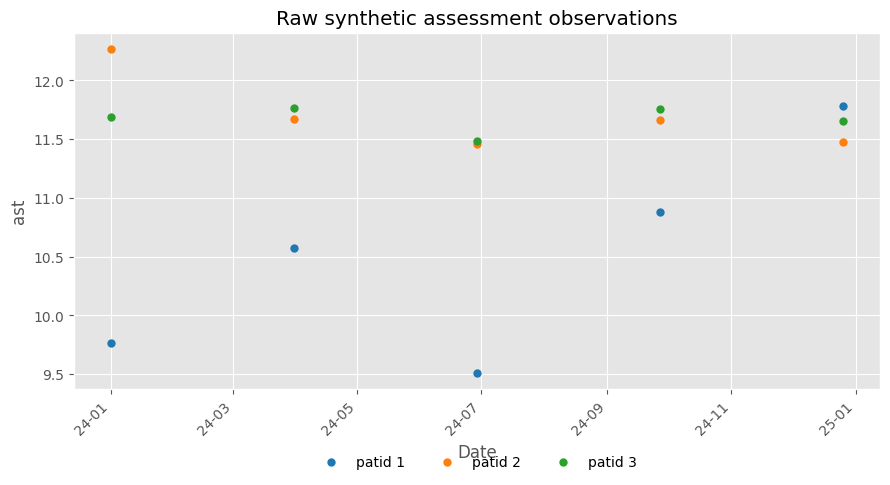

In [4]:
# Visualize synthetic assessment values per participant (scatter)
plot_raw_assessments(ast_df, score_col="ast", id_col="patid")

In [82]:
# Modes:
#   - "model"  : original behavior (predict daily deltas; clamp between prev/next actual)
#   - "linear" : force straight-line interpolation between every pair of assessments (pass-through)
#   - "segment_rescaled": use model daily deltas but rescale within each assessment-to-assessment segment
#                         so the cumulative change exactly equals the next assessment delta (pass-through)

# Per-person (single participant) example
# df_user_linear = predict_ast_scores(
#     sensor_df,
#     ast_df,
#     patid=1,
#     ast_col="ast",
#     seed_value=2015,
#     lr=1e-4,
#     epochs=30,
#     interpolate_mode="linear",           # "linear" | "segment_rescaled" | "model"
# )

# linear pass-through between each pair of assessments
interpolated_linear = process_and_interpolate_results(
    sensor_df,
    ast_df,
    score_columns=["ast"],
    seed_value=2015,
    lr=1e-4,
    epochs=30,
    interpolate_mode="linear",           # forwarded to predict_ast_scores via **train_kwargs
)

# model deltas, rescaled per segment to hit the next anchor
interpolated_rescaled = process_and_interpolate_results(
    sensor_df, ast_df, ["ast"], seed_value=2015, lr=1e-4, epochs=30,
    interpolate_mode="segment_rescaled"  
)

# clamped integration (adjust lr and epochs as needed)
interpolated_model = process_and_interpolate_results(
    sensor_df, ast_df, ["ast"], seed_value=2015, lr=1e-5, epochs=80,
    interpolate_mode="model"             
)


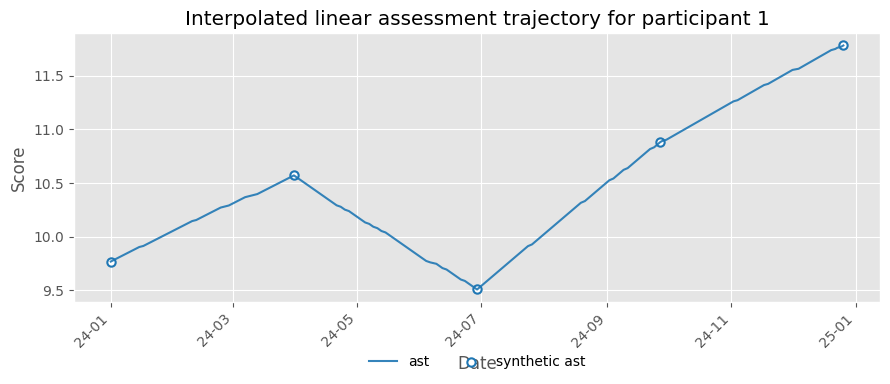

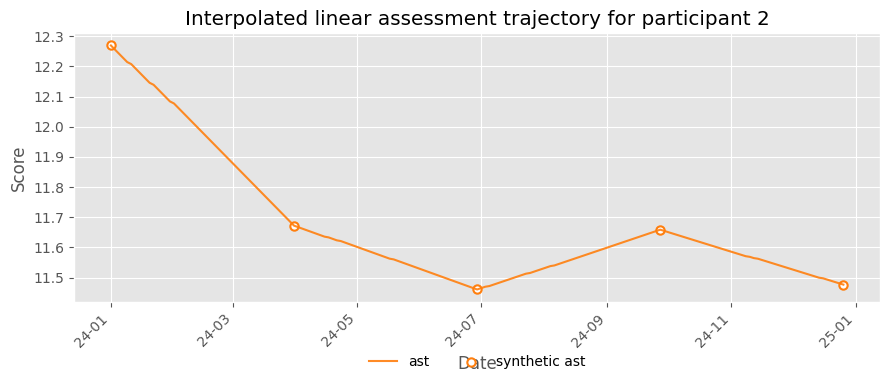

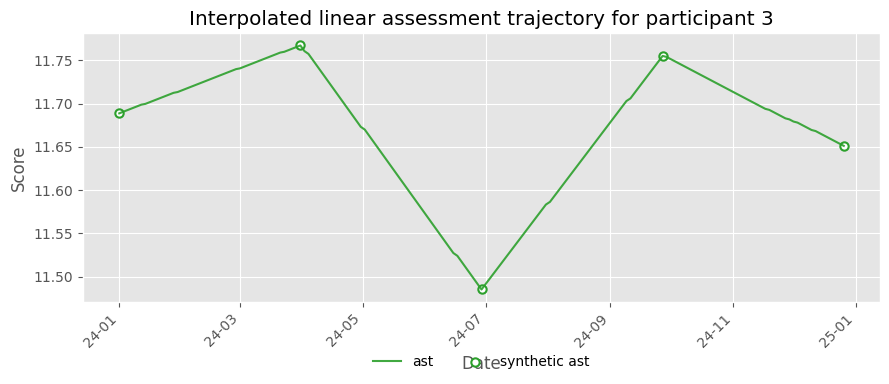

In [83]:
# Visualize interpoated assessment values per participant (line)
plot_pat_series_with_assessments(
    interpolated_linear,
    ast_df,
    score_cols=["ast"],
    title_prefix="Interpolated linear assessment trajectory"
)

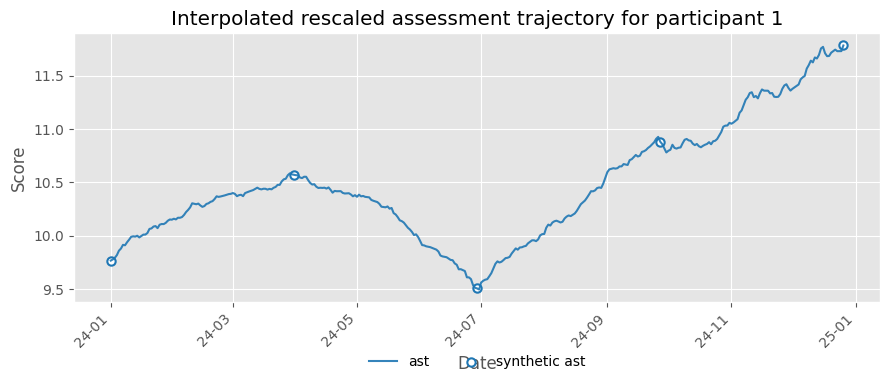

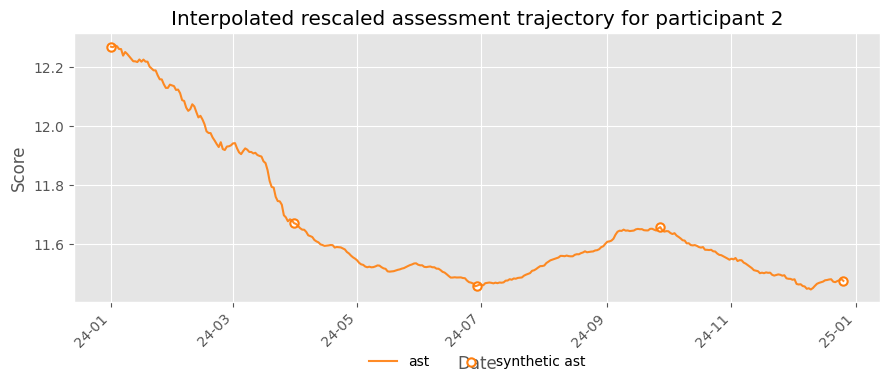

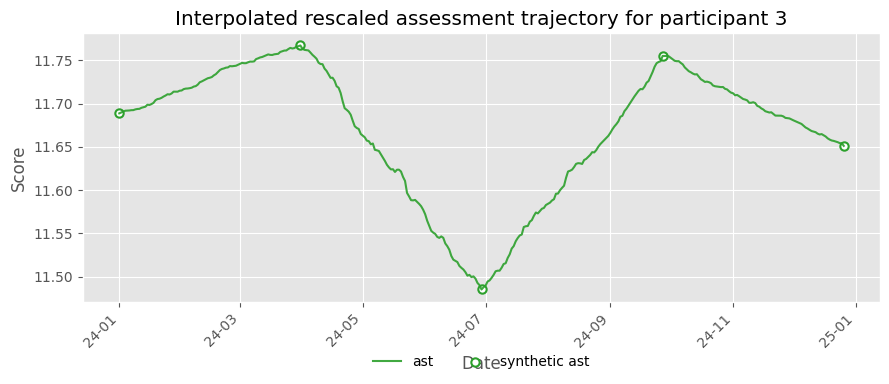

In [84]:
plot_pat_series_with_assessments(
    interpolated_rescaled,
    ast_df,
    score_cols=["ast"],
    title_prefix="Interpolated rescaled assessment trajectory"
)


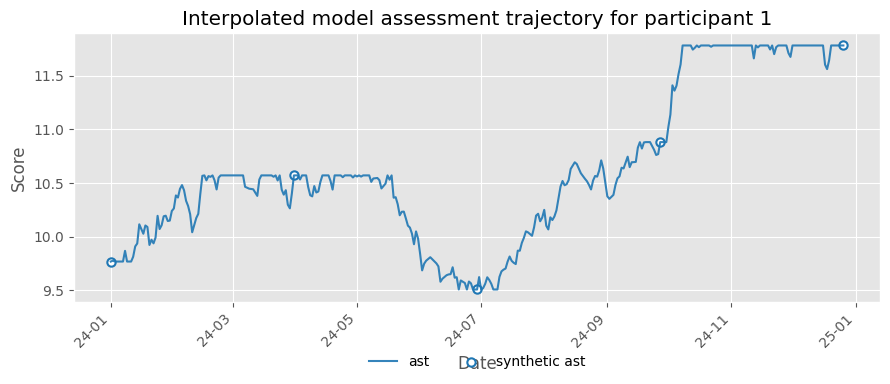

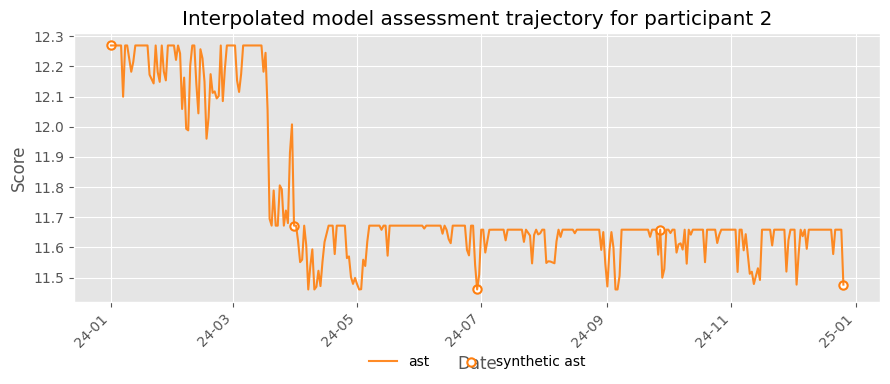

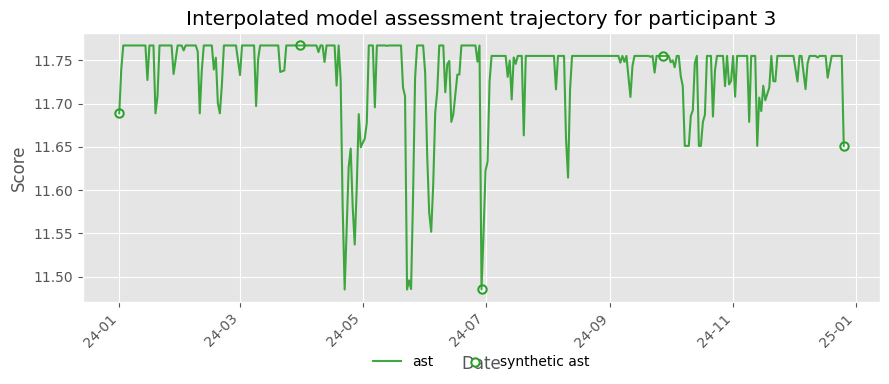

In [85]:
plot_pat_series_with_assessments(
    interpolated_model,
    ast_df,
    score_cols=["ast"],
    title_prefix="Interpolated model assessment trajectory"
)


In [86]:
# Ensemble + smooth
ensembled = ensemble_scores({"linear": interpolated_linear, "rescaled": interpolated_rescaled, "model": interpolated_model})
smoothed = smooth_results(ensembled, score_columns=["ast"], window=7)

display(ensembled.head())
display(smoothed.head())

,patid,date,ast
0,1,2024-01-01,9.767105
1,1,2024-01-02,9.776712
2,1,2024-01-03,9.782331
3,1,2024-01-04,9.793844
4,1,2024-01-05,9.810895


,patid,date,ast
0,1,2024-01-01,9.779998
1,1,2024-01-02,9.786177
2,1,2024-01-03,9.791951
3,1,2024-01-04,9.798183
4,1,2024-01-05,9.812993


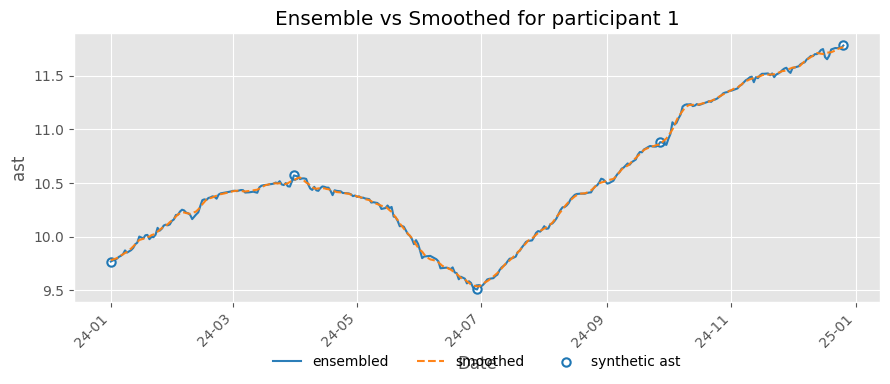

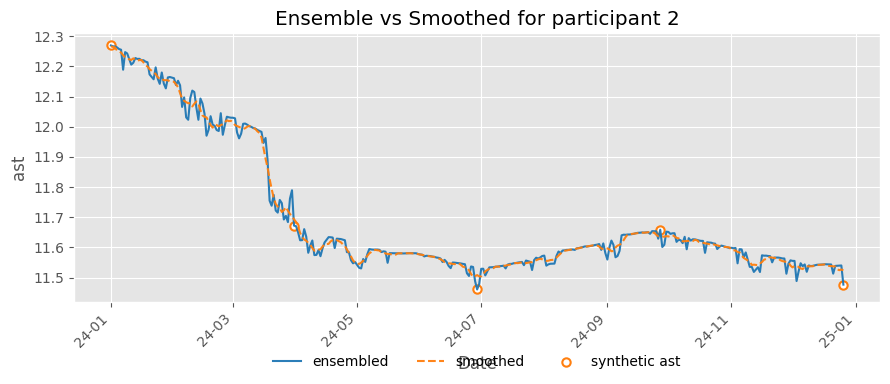

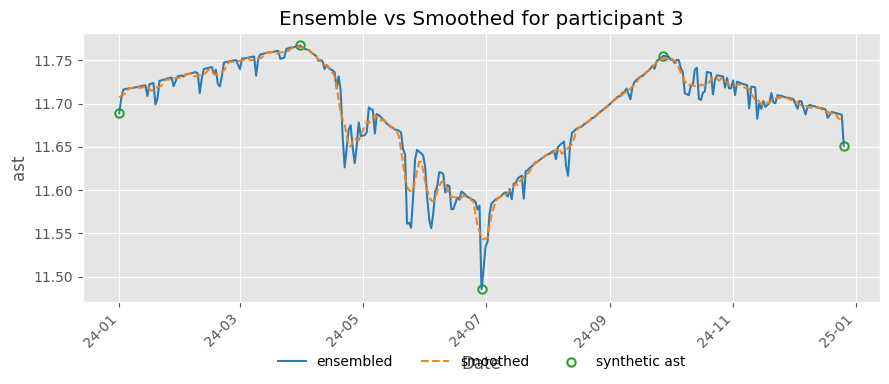

In [87]:
# Visualize ensembled scores with and without smoothing

# default line colors (tab10[0] for ensemble, tab10[1] for smoothed)
plot_ensemble_vs_smoothed_with_assessments(ensembled, smoothed, ast_df, score_col="ast")

# # custom line colors
# plot_ensemble_vs_smoothed_with_assessments(
#     ensembled, smoothed, ast_df,
#     score_col="ast",
#     line_colors=("tab:purple", "tab:green")
# )


In [88]:
# Save artifacts
OUTPUT_DIR = "./output"  # change this to wherever you want artifacts saved
os.makedirs(OUTPUT_DIR, exist_ok=True)

sensor_df.to_csv(os.path.join(OUTPUT_DIR, "sensor_df.csv"), index=False)
ast_df.to_csv(os.path.join(OUTPUT_DIR, "ast_df.csv"), index=False)
interpolated_linear.to_csv(os.path.join(OUTPUT_DIR, "interpolated_linear.csv"), index=False)
interpolated_rescaled.to_csv(os.path.join(OUTPUT_DIR, "interpolated_rescaled.csv"), index=False)
interpolated_model.to_csv(os.path.join(OUTPUT_DIR, "interpolated_model.csv"), index=False)
ensembled.to_csv(os.path.join(OUTPUT_DIR, "ensembled.csv"), index=False)
smoothed.to_csv(os.path.join(OUTPUT_DIR, "smoothed.csv"), index=False)

print(f"Artifacts saved to {OUTPUT_DIR}")


Artifacts saved to ./output
